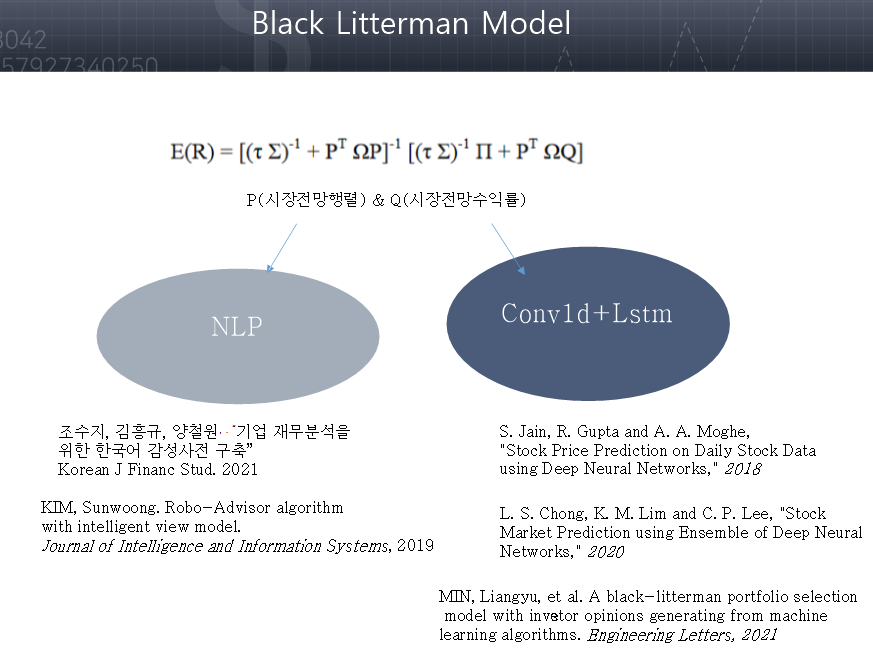

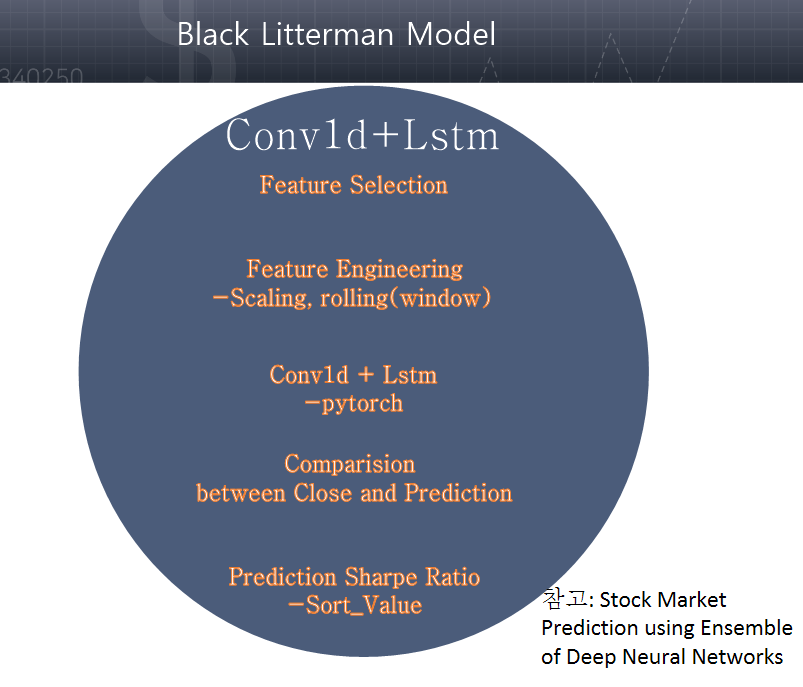

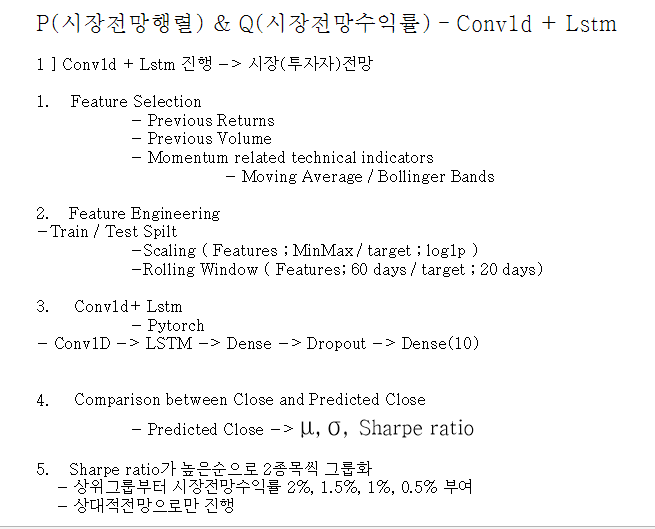

In [ ]:
!pip install IPython

In [ ]:
!pip install pykrx

In [ ]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

from pykrx import stock 
import datetime

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold

import torch
from torch.utils.data import DataLoader, Dataset 

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings(action='ignore')

torch.__version__


In [ ]:
pd.set_option('display.max_colum', None)

# Features
- Previous Returns  
- Rate of change of volume
- Volatility based indicators ex) Bollinger Bands,  Average True Range
- 선행지수 



# Data Set 준비 

In [ ]:
start = '20170101'
end = '20211231'
year = 1 

stock_names = ['Samsung', 'SkHynix', 'Samsung Bio', 'LG Chemical', 'NAVER', 'Hyundai Car', 'Samsung SDI', 'KAKAO' ]
stock_codes = ['005930', '000660', '207940', '051910', '035420', '005380', '006400', '035720']

list = []
for code in stock_codes:

    stock_data= stock.get_market_ohlcv_by_date(start, end, code)[['종가', '거래량']]
    list.append(stock_data)

# Close_df = pd.concat(list, axis=1)
# Close_df.columns = [stock_names]
# Close_df.head(10)



# Moving Average 

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

# 종가이동평균선 

class MA(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,x,y):
        return self
    def transform(self,x):
        x['MA5'] = x['Close'].rolling(window=5).mean() #5일평균
        x['MA10'] = x['Close'].rolling(window=10).mean() #10일평균
        x['MA20'] = x['Close'].rolling(window=20).mean() #20일평균
        x['MA60'] = x['Close'].rolling(window=60).mean() #60일평균
        x['MA120'] = x['Close'].rolling(window=120).mean() #120일 평균 
        return x

# 거래이동평균선 (Volume Adjusted Moving Average)

class VMA(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self,x,y=None):
        return self
    def transform(self,x):
        x['VMA5'] = x['Volume'].rolling(window=5).mean() 
        x['VMA10'] = x['Volume'].rolling(window=10).mean()
        x['VMA20'] = x['Volume'].rolling(window=20).mean()
        x['VMA60'] = x['Volume'].rolling(window=60).mean()
        x['VMA120'] = x['Volume'].rolling(window=120).mean()
        return x

# 볼린져밴드생성 
class bolinger(BaseEstimator,TransformerMixin):
    def __init__(self):
        pass
    def fit(self,x,y):
        return self
    def transform(self,x):
        x['std'] = x['Close'].rolling(window=20).std() # 볼린저 밴드 상한선, 하한선을 구하기 위한 20일 주가 표준편차 
        x['20_Upper'] = x['MA20'] + 2 * x['std'] # 볼린저 밴드의 상한선 : 20일 이평선 값 + (20일동안의 주가 표준편차 값)*2
        x['20_Lower'] = x['MA20'] - 2 * x['std'] # 볼린저 밴드의 하한선 : 20일 이평선 값 - (20일동안의 주가 표준편차 값)*2
        x.drop('std',axis=1,inplace=True)
        x.dropna(inplace=True)
        return x



In [ ]:
from sklearn.pipeline import Pipeline 

data_pipeline = Pipeline([
    ('MA',MA()),
    ('VMA',VMA()),
    ('Bolinger',bolinger()),
])
# FB = data_pipeline.transform(FB) #Null값 자동으로 처리 (2012-11-08) 데이터부터 나옴 

In [ ]:
from sklearn.pipeline import Pipeline 

data_pipeline = Pipeline([
    ('MA',MA()),
    ('VMA',VMA()),
    ('Bolinger',bolinger()),
#     ('Close_MA',Close_MA()),
#     ('Close_Vol',Close_Vol()),
])
# FB = data_pipeline.transform(FB) #Null값 자동으로 처리 (2012-11-08) 데이터부터 나옴 

In [ ]:
def add_column (df= list[0]):

    df['return'] = (df.종가 - df.종가.shift(1) ) / df.종가.shift(1)
    df.columns = ['Close', 'Volume', 'Return']
    
    df = data_pipeline.transform(df) #Null값 자동으로 처리 (2012-11-08) 데이터부터 나옴 
    
#     df['Return_20'] = df['Return'].rolling(window=20).mean() * 20
#     df.dropna(inplace=True)

    return df 


df_list = []
for i in list:
    added_df= add_column(df=i)
    df_list.append(added_df)




In [ ]:
df_list[0]

# Visualization for key features

In [ ]:
def plot_MA(data): #이동평균 표현 
    %matplotlib inline
    plt.figure(figsize=(30,10))
    plt.rc('font',size=20)
    plt.plot(data['Close'],label='Close')
    plt.plot(data['MA5'],label='MA5',)
    plt.plot(data['MA10'],label='MA10')
    plt.plot(data['MA20'],label='MA20')
    plt.plot(data['MA60'],label='MA60')
    plt.plot(data['MA120'],label='MA120')
    plt.xlabel('Year')
    plt.ylabel('Indics')
    plt.legend(fontsize=30)
    plt.grid(True)
    return plt.show()

In [ ]:
def plot_VMA(data): #거래이동평균 표현
    %matplotlib inline
    plt.figure(figsize=(30,10))
    plt.rc('font',size=20)
    plt.plot(data['Volume'],label='Volume')
    plt.plot(data['VMA5'],label='VMA5',)
    plt.plot(data['VMA10'],label='VMA10')
    plt.plot(data['VMA20'],label='VMA20')
    plt.plot(data['VMA60'],label='VMA60')
    plt.plot(data['VMA120'],label='VMA120')
    plt.ylabel('Volume')
    plt.xlabel('year')
    plt.legend(fontsize=30)
    plt.grid(True)
    return plt.show()

In [ ]:
def bol_plot(data): # 블렌저밴드 표현
    plt.figure(figsize=(30,10))
    plt.rc('font',size=20)
    plt.plot(data['Close'],color='black',label='Close_price')
    plt.plot(data['20_Upper'],ls='--',color='red',label='Uper Band')
    plt.plot(data['20_Lower'],ls='--',color='blue',label='Lower Band')
    plt.xlabel('Date')
    plt.ylabel('Indics')
    plt.legend()
    plt.grid(True)
    return plt.show()

#### Close Moving Average 

In [ ]:
plot_MA(df_list[0])

#### Volume Moving Average 

In [ ]:
plot_VMA(df_list[0])

#### Bollinger Band 

In [ ]:
bol_plot(df_list[0])

# 데이터 나누기 feature, label 

In [ ]:

df_feature_list = []
df_label_list = []
def get_split (df=df_list[0]):

    df_feature = df.iloc[:, 1:]
    df_label = df.iloc[:, 0]
    
    return df_feature, df_label 

for df in df_list:
    df_feature, df_label = get_split(df=df)
    df_feature_list.append(df_feature)
    df_label_list.append(df_label)



In [ ]:
 df_label_list[0]

# 스케일링 (data feature_ X scaling 진행) 

## MinMax scaling 

In [ ]:
from sklearn.preprocessing import MinMaxScaler


def scaling(df_feature = df_feature_list[0]):

    #feature scaling 
    scaler = MinMaxScaler(feature_range=(-1, 1))
    df_feature_scaled = scaler.fit_transform(df_feature)
    df_feature = pd.DataFrame(df_feature_scaled, columns=df_feature.columns)
    
    
    
    
    return df_feature

list_df_feature =[]
for d in df_feature_list:
    
    df_feature= scaling(df_feature =d)
    list_df_feature.append(df_feature)

    
list_df_label = df_label_list
df_label_list[0]


# Deep Learning

## Train, Test split


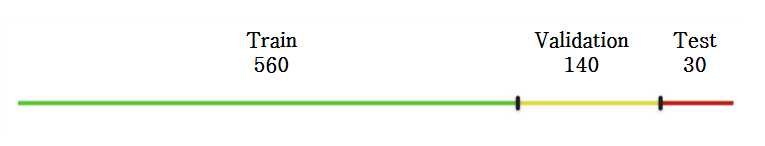

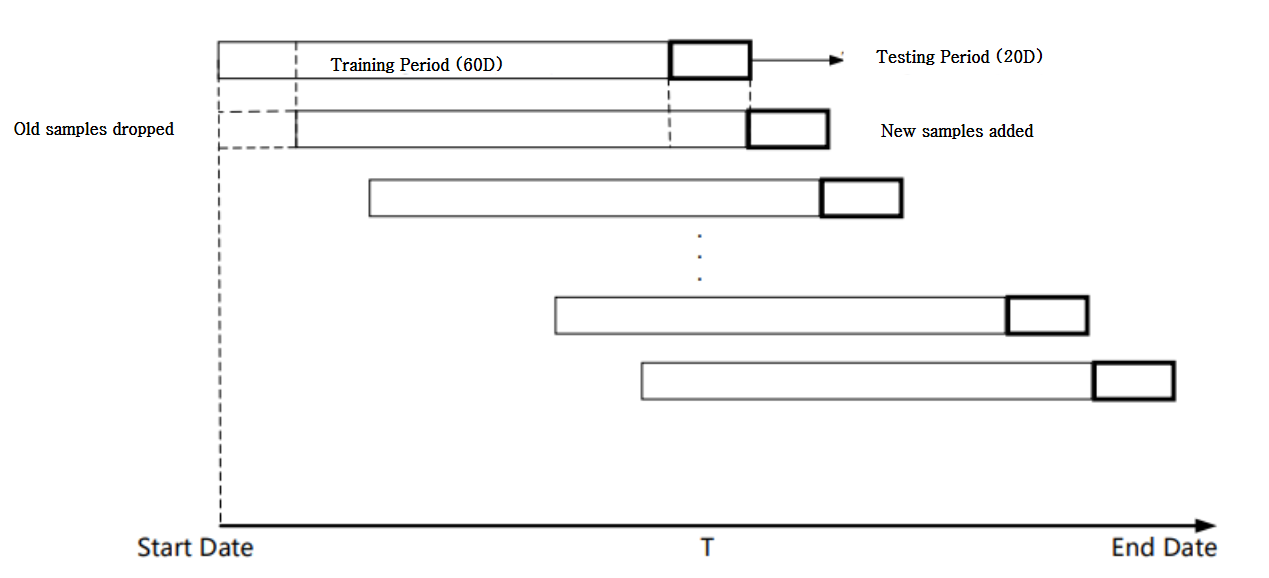



In [ ]:


def get_train_test (df_feature= df_feature, df_label= df_label):

    X_train = df_feature.iloc[:-100, :]
    X_test = df_feature.iloc[-100:, :]
    y_train = df_label.iloc[:-100]
    y_test = df_label.iloc[-100:]
    
    return X_train, X_test, y_train, y_test

# print ( X_train.shape, X_test.shape, y_train.shape, y_test.shape)
# print (len(X_train))

# y_test.index

X_train_list =[]
X_test_list=[]
y_train_list=[]
y_test_list=[]
for f, l in zip(list_df_feature, list_df_label):
    
    X_train, X_test, y_train, y_test = get_train_test (f, l)
    X_train_list.append(X_train)
    X_test_list.append(X_test)
    y_train_list.append(y_train)
    y_test_list.append(y_test)

In [ ]:
X_train_list[0]

In [ ]:
# deep learning dataset 재구성 (데이터를 60일 단위로 묶어 재구성)

def make_DL_dataset (feature, label, window_size=20):
    feature_list = []
    label_list = []

    for i in range(len(feature) - (window_size*4)): 
        a = np.array(feature.iloc[i:i+window_size])
        feature_list.append(np.array(feature.iloc[i:i+window_size*3])) #1~60일 (영업일기준 한달)
        label_list.append(np.array(label.iloc[i+window_size*3:i+window_size*4])) #60~80일 
    return np.array(feature_list), np.array(label_list)


list_X_train_60 =[]
X_test_60_list=[]
list_y_train_60=[]
y_test_60_list=[]


for x, y in zip(X_train_list, y_train_list):
    
    X_train_l, y_train_l = make_DL_dataset (x, y, window_size=20)
    
    list_X_train_60.append(X_train_l)
    list_y_train_60.append(y_train_l)

for x, y in zip(X_test_list, y_test_list):
    
    X_test_l, y_test_l = make_DL_dataset (x, y, window_size=20)
    
    X_test_60_list.append(X_test_l)
    y_test_60_list.append(y_test_l)
   





In [ ]:
X_train_60_list=[]
y_train_60_list=[]
for x, y in zip(list_X_train_60, list_y_train_60):

    x_iloc = x[-700:] 
    y_iloc = y[-700:]
    X_train_60_list.append(x_iloc)
    y_train_60_list.append(y_iloc)


In [ ]:
print(X_train_60_list[0].shape, X_test_60_list[0].shape, y_train_60_list[0].shape, y_test_60_list[0].shape)

# Dataset to Tensor

In [ ]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data import ConcatDataset

def get_tensor_Dataset(X_train=X_train_60_list[0], y_train=y_train_60_list[0], X_test=X_test_60_list[0], y_test=y_test_60_list[0]):

    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    Dataset_train = TensorDataset(X_train_tensor, y_train_tensor)

    X_test_tensor = torch.FloatTensor(X_test)
    y_test_tensor = torch.FloatTensor(y_test)
    Dataset_test = TensorDataset(X_test_tensor, y_test_tensor)

    return Dataset_train, Dataset_test

Dataset_train_list=[]
Dataset_test_list=[] 
for X_60, y_60 in zip (X_train_60_list, y_train_60_list):

    Dataset_train, Dataset_test = get_tensor_Dataset(X_60, y_60, X_60, y_60)
    Dataset_train_list.append(Dataset_train)
    Dataset_test_list.append(Dataset_test)



# --------------------------------------------------------------------------------------------

def get_Dataloader (Dataset_train=Dataset_train, Dataset_test= Dataset_test, batch_size=10):
  
    Dataloader_train = torch.utils.data.DataLoader(Dataset_train, batch_size=10, shuffle=False, num_workers=0) # 텐서화된 X_train과 y_train을 batch_size로 잘라 돌려줌
    Dataloader_test = torch.utils.data.DataLoader(Dataset_test, batch_size=10, shuffle=False, num_workers=0) # 텐서화된 X_test와 y_test을 batch_size로 잘라 돌려줌

    return Dataloader_train, Dataloader_test


Dataloader_train_list=[]
Dataloader_test_list=[]

for Dataset_train, Dataset_test in zip(Dataset_train_list, Dataset_test_list):

    Dataloader_train, Dataloader_test = get_Dataloader (Dataset_train, Dataset_test, 10)
    Dataloader_train_list.append(Dataloader_train)
    Dataloader_test_list.append(Dataloader_test)
    

# 향후 KFold를 위해 Dataset_train과 Dataset_test를 concat시킨 Dataset 생성 

Dataset_list = []

for Dataset_train, Dataset_test in zip( Dataset_train_list, Dataset_test_list ):
    Dataset = ConcatDataset([Dataset_train, Dataset_test ])
    Dataset_list.append(Dataset)


In [ ]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")


# DeepLearning Model 

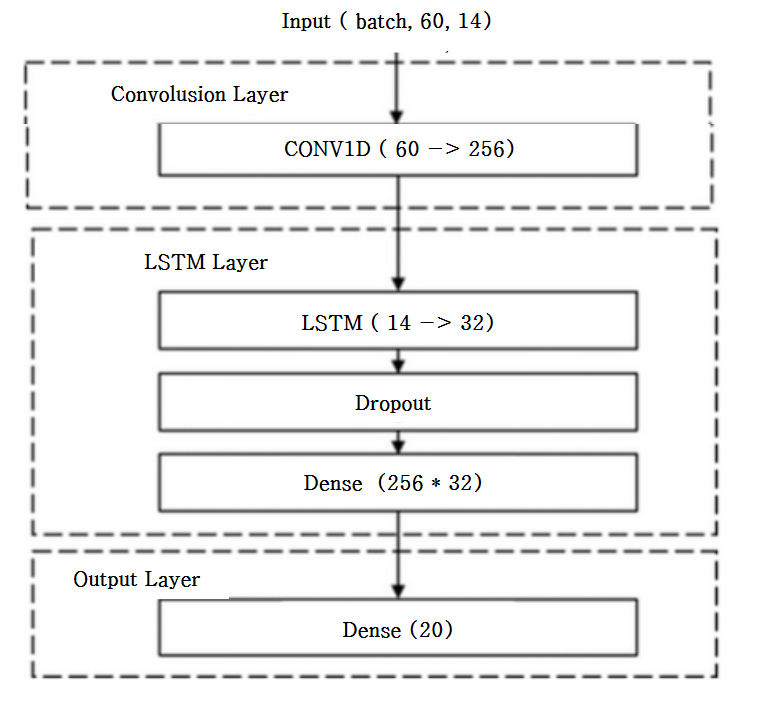

In [ ]:
import torch.nn as nn

# weight, bias 초기화 

def weight_init (submodule):
    if isinstance(submodule, torch.nn.Conv1d):
        torch.nn.init.kaiming_normal(submodule.weight)
        submodule.bias.data.fill_(0.01)
    elif isinstance(submodule, torch.nn.Linear or nn.LSTM):
        torch.nn.init.xavier_normal(submodule.weight)
        submodule.bias.data.fill_(0.01)


class Model(nn.Module):
    def __init__(self, num_layers=4, p=0.25):
        super(Model, self).__init__()
        self.con_layer = nn.Sequential(
            nn.Conv1d(60,128,1), #expect 60 channel 
            nn.BatchNorm1d(128), #batchnorm을 진행시 weight initialization을 진행해줄 필요 x / conv이후, Activation 적용 전 진행  
            nn.ReLU(),
           # nn.Dropout(p=p), #dropout은 flatten이후 진행 

            nn.Conv1d(128,256,1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
           # nn.Dropout(p=p),

#             nn.Conv1d(128,64,1),
#             nn.BatchNorm1d(64),
#             nn.ReLU(),
#            # nn.Dropout(p=p),

#             nn.Conv1d(64,5,1),
#             nn.BatchNorm1d(5),
#             nn.ReLU(),
#            # nn.Dropout(p=p)

            )
        
        #lstm [features, features in hidden, recurrent layers]

        self.lstm1 =torch.nn.LSTM(14,64, num_layers= num_layers)
        self.bnn1 = nn.BatchNorm1d(256)
        self.tanh1 = nn.Tanh()
       # self.dropout = nn.Dropout(p=p)


        self.lstm2 =nn.LSTM(64,128, num_layers= num_layers)
        self.bnn2 = nn.BatchNorm1d(256)
        self.tanh2 = nn.Tanh()
       # self.dropout = nn.Dropout(p=p)

        self.lstm3 =nn.LSTM(128,64, num_layers= num_layers)
        self.bnn3 = nn.BatchNorm1d(256)
        self.tanh3 = nn.Tanh()
       # self.dropout = nn.Dropout(p=p)

        self.lstm4 =nn.LSTM(64,32, num_layers= num_layers)
        self.bnn4 = nn.BatchNorm1d(256)
        self.tanh4 = nn.Tanh()
       # self.dropout = nn.Dropout(p=p)

        #중요 
        self.flatten = nn.Flatten()

        self.linear_layer = nn.Sequential(
            nn.Linear(256*32, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(p=p),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(p=p),
            
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=p),


            nn.Linear(128, 20),
            nn.ReLU()
            # 마지막은 batchnorm, droupout 제외 
            )


    def forward(self, x):
        x = self.con_layer(x)
        x, states = self.lstm1(x)
        x = self.tanh1(self.bnn1(x))
        x, states = self.lstm2(x)
        x = self.tanh2(self.bnn2(x))
        x, states = self.lstm3(x)
        x = self.tanh3(self.bnn3(x))
        x, states = self.lstm4(x)
        x = self.tanh4(self.bnn4(x))
        x = x.flatten(1) #20*256로 변함
        output = self.linear_layer(x)
        #output = output.view(-1)

        return output
    
model = Model()
model.apply(weight_init)
#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#model.to(device)

#torch.save('Model', model)

model

In [ ]:
import warnings 
warnings.filterwarnings('ignore')

# 베이지안 

from hyperopt import hp, STATUS_OK

DL_search_space = {'num_layers': hp.quniform('num_layers', 1, 10, 1),
                    'p': hp.uniform('p', 0.01, 0.8),
                    'lr':hp.uniform('lr', 0.001, 0.01)                   
               }

from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

def objective_func(search_space):
    model = Model(num_layers=int(search_space['num_layers']), 
                p=search_space['p']
                )

    #model.apply(weight_init)
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    model.to(device)  

    optimizer = optim.Adam(model.parameters(), lr=0.05)
    mse_loss = F.mse_loss

    epochs = 1
    train_loss = []
    train_acc =[]

    for epoch in range(epochs):

        model.train()
        total_train = 0
        total_train_loss = 0
        total_train_acc = 0


        tqdm_dataloader_train = tqdm(Dataloader_train_list[0]) #batchsize=128로 불러온 train dataset (tensor)
        for idx, (X_train, y_train) in enumerate(tqdm_dataloader_train, 0): #128개씩 나눠서 차례대로 넣어줘 (언제까지? 2568개 찰때까지 = 1epoch) 

            X_train, y_train = X_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            pred_y = model(X_train)

            loss = torch.sqrt(mse_loss(pred_y, y_train)) #RMSE로 변환 
            print(f'rmse_loss:{loss}, status: {STATUS_OK}')
            total_train_loss += loss.item()

            loss.backward()
            optimizer.step()

            total_train = total_train +1

        total_train_acc = total_train_acc / (idx +1) #1epoch이 돌았을때의 평균 acc를 total_acc list에 넣어주고 epoch 1일때의 값을 print해줌
        train_acc.append(total_train_acc)

        total_train_loss = total_train_loss / (idx +1) #1epoch이 모두 돌았을때의 평균 loss를 total_loss list에 epoch 1일때의 total_loss(batch 20번 돌렸을때의 평균 loss)를 돌려줌 
        train_loss.append(total_train_loss)

        #print(f'/nEpoch: {epoch}/{epochs}, Train Loss: {total_train_loss:.4f}, Train Acc:{total_train_acc:.4f}')
        print(f'/nEpoch: {epoch}/{epochs}, Train Loss: {total_train_loss:.4f}')

        print(f"epochs 20's each total_loss(batch 평균)_list : {total_train_loss}")
#         print(f"epochs 20's each total_acc(batch 평균)_list : {total_acc}")
        return {'loss': total_train_loss, 'status' : STATUS_OK}  # 모든 epochs를 돌리고 난 후 최종 loss를 

from hyperopt import fmin, tpe, Trials, space_eval, STATUS_OK

trial_val = Trials()
best = fmin(fn=objective_func,
            space=DL_search_space,
            algo=tpe.suggest,
            max_evals=20, # 최대 반복 횟수
            trials=trial_val)

print(space_eval(DL_search_space, best))
print('best:', best)

In [ ]:
# best 하이퍼파라미터로 튜닝 

model = Model(num_layers=int(best['num_layers']),
                             p=round(best['p'],5)                          
                             )

#model.apply(weight_init)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)


In [ ]:
def indices_binarizer(target,prediction):
    target_result = []
    prediction_result = []
    for i,indices in enumerate(target):
        if i == 0:
            target_result.append(0)
            data = indices
        if indices >= data:
            pred = 1
            target_result.append(pred)
            data = indices
        if indices < data:
            pred = 0
            target_result.append(pred)
            data = indices
    for i,indices in enumerate(prediction):
        if i == 0:
            prediction_result.append(0)
            pred_data = indices
        if indices >= data:
            pred = 1
            prediction_result.append(pred)
            pred_data = indices
        if indices < data:
            pred = 0
            prediction_result.append(pred)
            pred_data = indices
    return target_result, prediction_result

In [ ]:
class EarlyStopping:
    """주어진 patience 이후로 validation loss가 개선되지 않으면 학습을 조기 중지"""
    def __init__(self, patience=20, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): validation loss가 개선된 후 기다리는 기간
                            Default: 7
            verbose (bool): True일 경우 각 validation loss의 개선 사항 메세지 출력
                            Default: False
            delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화
                            Default: 0
            path (str): checkpoint저장 경로
                            Default: 'checkpoint.pt'
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''validation loss가 감소하면 모델을 저장한다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

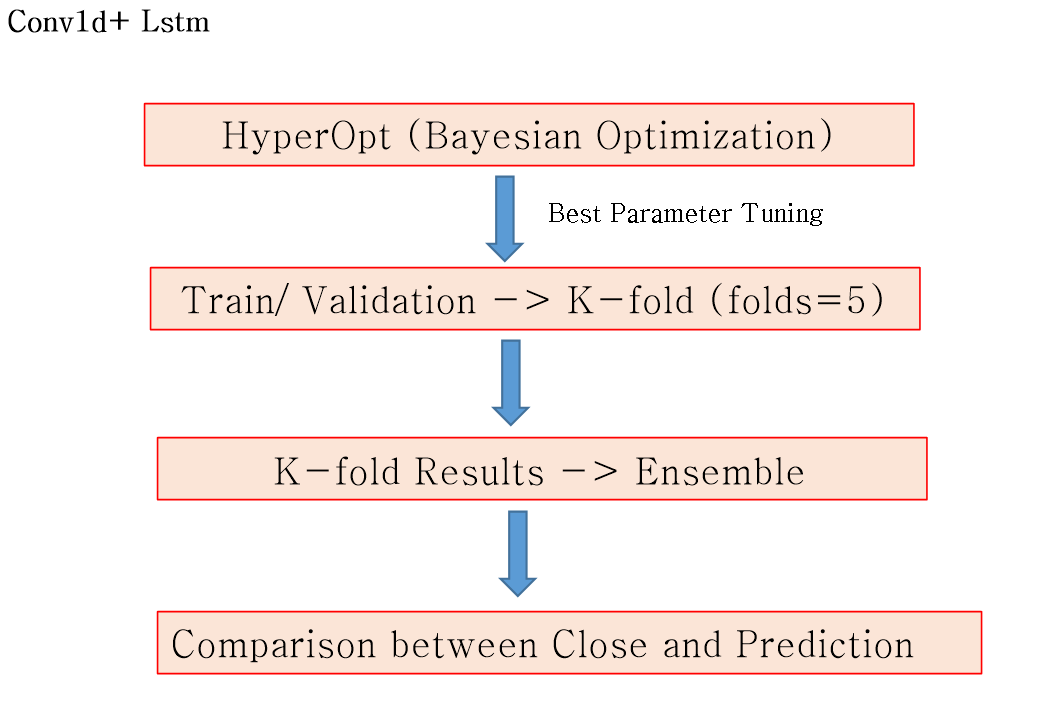

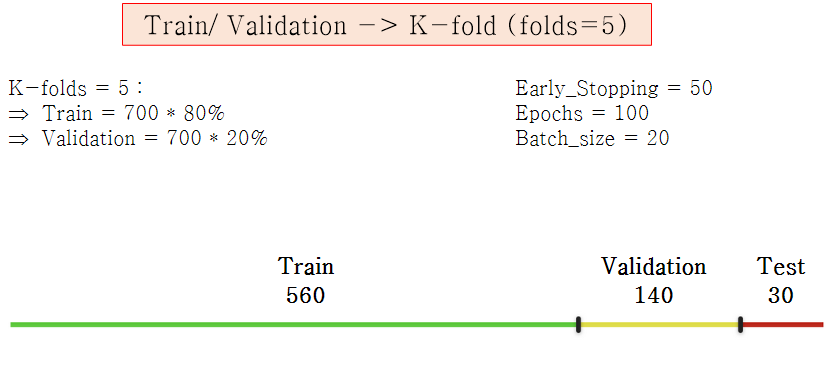

In [ ]:

from torch import optim
import torch.nn.functional as F
from tqdm import tqdm 
from sklearn.metrics import mean_squared_error,accuracy_score
from hyperopt import fmin, tpe, Trials, space_eval, STATUS_OK

#train_set/ test_set 중 train_set에 대해서 k-fold 진행 
#train_set (2568, 5, 27) -> kfold = 5 -> train_set & valid_set 

# fold results  


model = Model(num_layers=int(best['num_layers']),
                             p=round(best['p'],5)                          
                             )

#model.apply(weight_init)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)


kfold = KFold(n_splits=4, shuffle=False)

print('-'*50)

model_result = []
fold = 1
for fold, (train_idx, valid_idx) in enumerate(kfold.split(Dataset_train_list[0])): #dataset은 아직 batchsize 정하기이전!! 

    print(f'FOLD {fold}')
    print('-'*50)
  
    # index 가져오기 
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx) # 2568 중 4/5를 random으로 가져옴 (shuffle의 개념)
    valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_idx) # 2568 중 1/5

    # trainloader, validloader 선언 

    trainloader = torch.utils.data.DataLoader(Dataset_train, batch_size=20, sampler=train_subsampler)
    # 2568 중 4/5인 2054개를 minibatch로 10개씩 가져옴 
    validloader = torch.utils.data.DataLoader(Dataset_train, batch_size=20, sampler=valid_subsampler)
    # 2568 중 1/5인 513개를 minibatch로 10개씩 가져옴 

    list_lr = [best['lr']] # best lr로 튜닝 

    for lr in list_lr:
        optimizer = optim.Adam(model.parameters(), lr=lr)
        mse_loss = F.mse_loss

        print(f'fold: {fold}, lr:{lr}')
        print('-'*50)

        epochs = 20
        train_loss = []
        valid_loss = []
        train_acc =[]
        valid_acc = []

        early_stopping = EarlyStopping(patience = 10, verbose = True, path='checkpoint.pt'+str(fold))


    for epoch in range(epochs):

        total_train_loss = 0
        total_train_acc = 0
        total_valid_loss = 0
        total_valid_acc = 0

  # model training 
  
        model.train()
        total_train = 0
      
        tqdm_dataloader_train = tqdm(trainloader) 
        for idx, (X_train, y_train) in enumerate(tqdm_dataloader_train, 0): #batchsize=10개씩 2568의 4/5 (trainset의 크기) 만큼반복: 207번 (1epoch당)

            X_train, y_train = X_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            pred_y = model(X_train)

            loss = torch.sqrt(mse_loss(pred_y, y_train)) #RMSE로 변환 
            total_train_loss += loss.item() # batch가 돌때마다 나오는 loss를 계속 더해줌 -> 향후 207번 (1epoch)이 다 돌면 1epoch의 평균 loss를 구하기 위함 

            loss.backward()
            optimizer.step()

            total_train = total_train +1

            #target_binary, pred_binary = indices_binarizer(y_train,pred_y)
            #acc = accuracy_score(target_binary,pred_binary)

            #total_train_acc += acc.item()

      
        #total_train_acc = total_train_acc / (idx +1)
        #train_acc.append(total_train_acc)  # 207번의 batch에서 나온 1epoch의 평균을 list안에 더해줌 

        total_train_loss = total_train_loss / (idx +1)
        train_loss.append(total_train_loss)

      


    # validation 
        model.eval()
        total_valid = 0

        tqdm_dataloader_valid = tqdm(validloader) 
        for idx, (X_valid, y_valid) in enumerate(tqdm_dataloader_valid, 0):


            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            pred = model(X_valid)


            loss_valid = torch.sqrt(mse_loss(pred, y_valid)) #RMSE로 변환 
            total_valid_loss += loss_valid.item()


            total_valid = total_valid +1

            #target_binary, pred_binary = indices_binarizer(y_valid,pred)
            #acc = accuracy_score(target_binary,pred_binary)

            #total_valid_acc += acc.item()

      
        #total_valid_acc = total_valid_acc / (idx +1)
        #valid_acc.append(total_valid_acc)

        total_valid_loss = total_valid_loss / (idx +1)
        valid_loss.append(total_valid_loss)

      

        early_stopping(total_valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
      
      
      
        #print(f'pred: {pred[-1]}')
        #print(f'y_valid: {y_valid[-1]}')
        if epoch % 5 == 0:
            #print('Epoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc : {:.4f}'.format(epoch, epochs, total_train_loss, total_valid_loss, total_valid_acc))
            print('Epoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, epochs, total_train_loss, total_valid_loss))
    model.load_state_dict(torch.load('checkpoint.pt' + str(fold)))
    model_result.append(model)
    fold += 1

In [ ]:
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm 
from sklearn.metrics import mean_squared_error,accuracy_score
from hyperopt import fmin, tpe, Trials, space_eval, STATUS_OK

#train_set/ test_set 중 train_set에 대해서 k-fold 진행 
#train_set (2568, 5, 27) -> kfold = 5 -> train_set & valid_set 

# fold results  


model = Model(num_layers= 5,
              p=0.5)                          

#model.apply(weight_init)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model.to(device)


kfold = KFold(n_splits=4, shuffle=False)

print('-'*50)

model_result = []
fold = 1
for fold, (train_idx, valid_idx) in enumerate(kfold.split(Dataset_train_list[0])): #dataset은 아직 batchsize 정하기이전!! 

    print(f'FOLD {fold}')
    print('-'*50)
  
    # index 가져오기 
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx) # 2568 중 4/5를 random으로 가져옴 (shuffle의 개념)
    valid_subsampler = torch.utils.data.SubsetRandomSampler(valid_idx) # 2568 중 1/5

    # trainloader, validloader 선언 

    trainloader = torch.utils.data.DataLoader(Dataset_train, batch_size=20, sampler=train_subsampler)
    # 2568 중 4/5인 2054개를 minibatch로 10개씩 가져옴 
    validloader = torch.utils.data.DataLoader(Dataset_train, batch_size=20, sampler=valid_subsampler)
    # 2568 중 1/5인 513개를 minibatch로 10개씩 가져옴 

    list_lr = [0.01] # vest lr로 튜닝 

    for lr in list_lr:
        optimizer = optim.Adam(model.parameters(), lr=lr)
        mse_loss = F.mse_loss

        print(f'fold: {fold}, lr:{lr}')
        print('-'*50)

        epochs = 200
        train_loss = []
        valid_loss = []
        train_acc =[]
        valid_acc = []

        early_stopping = EarlyStopping(patience = 50, verbose = True, path='checkpoint.pt'+str(fold))


    for epoch in range(epochs):

        total_train_loss = 0
        total_train_acc = 0
        total_valid_loss = 0
        total_valid_acc = 0

  # model training 
  
        model.train()
        total_train = 0
      
        tqdm_dataloader_train = tqdm(trainloader) 
        for idx, (X_train, y_train) in enumerate(tqdm_dataloader_train, 0): #batchsize=10개씩 2568의 4/5 (trainset의 크기) 만큼반복: 207번 (1epoch당)

            X_train, y_train = X_train.to(device), y_train.to(device)
            optimizer.zero_grad()
            pred_y = model(X_train)

            loss = torch.sqrt(mse_loss(pred_y, y_train)) #RMSE로 변환 
            total_train_loss += loss.item() # batch가 돌때마다 나오는 loss를 계속 더해줌 -> 향후 207번 (1epoch)이 다 돌면 1epoch의 평균 loss를 구하기 위함 

            loss.backward()
            optimizer.step()

            total_train = total_train +1

            #target_binary, pred_binary = indices_binarizer(y_train,pred_y)
            #acc = accuracy_score(target_binary,pred_binary)

            #total_train_acc += acc.item()

      
        #total_train_acc = total_train_acc / (idx +1)
        #train_acc.append(total_train_acc)  # 207번의 batch에서 나온 1epoch의 평균을 list안에 더해줌 

        total_train_loss = total_train_loss / (idx +1)
        train_loss.append(total_train_loss)

      


    # validation 
        model.eval()
        total_valid = 0

        tqdm_dataloader_valid = tqdm(validloader) 
        for idx, (X_valid, y_valid) in enumerate(tqdm_dataloader_valid, 0):


            X_valid, y_valid = X_valid.to(device), y_valid.to(device)
            pred = model(X_valid)


            loss_valid = torch.sqrt(mse_loss(pred, y_valid)) #RMSE로 변환 
            total_valid_loss += loss_valid.item()


            total_valid = total_valid +1

            #target_binary, pred_binary = indices_binarizer(y_valid,pred)
            #acc = accuracy_score(target_binary,pred_binary)

            #total_valid_acc += acc.item()

      
        #total_valid_acc = total_valid_acc / (idx +1)
        #valid_acc.append(total_valid_acc)

        total_valid_loss = total_valid_loss / (idx +1)
        valid_loss.append(total_valid_loss)

      

        early_stopping(total_valid_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break
      
      
      
        #print(f'pred: {pred[-1]}')
        #print(f'y_valid: {y_valid[-1]}')
        if epoch % 5 == 0:
            #print('Epoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}, Val Acc : {:.4f}'.format(epoch, epochs, total_train_loss, total_valid_loss, total_valid_acc))
            print('Epoch: {}/{}, Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch, epochs, total_train_loss, total_valid_loss))
    model.load_state_dict(torch.load('checkpoint.pt' + str(fold)))
    model_result.append(model)
    fold += 1

In [ ]:
# test / ensemble 

ensemble_pred = []
ensemble_y_test = []
for i in range(4):
    model.load_state_dict(torch.load(f'checkpoint.pt{i}'))
    model.eval()
    device = ('cuda' if torch.cuda.is_available() else 'cpu')
    with torch.no_grad():
        for i, (X_test, y_test) in enumerate(Dataloader_test):
            X_test, y_test = X_test.to(device).float(), y_test.to(device).float()
            pred = model(X_test).detach().cpu().numpy()
            y_test = y_test.detach().cpu().numpy()
            ensemble_pred.append(pred)
            ensemble_y_test.append(y_test)

                
pred =np.mean(ensemble_pred, axis=0)
pred = torch.Tensor(pred)
y_test = np.mean(ensemble_y_test, axis=0)
y_test = torch.Tensor(y_test)
loss_test = torch.sqrt(mse_loss(pred, y_test)) #RMSE로 변환 
total_valid = total_valid +1

#target_binary, pred_binary = indices_binarizer(y_test,pred)
# acc = accuracy_score(target_binary,pred_binary)
print(f'pred_test:{pred[-1]}, \n y_test:{y_test[-1]}')
#print(f'rmse:{loss_test}, accuracy:{acc}')
print(f'rmse:{loss_test}')

In [ ]:
def print_result(pred):
    pred = pred.reset_index()
    high = pred.pred.max()
    low = pred.pred.min()
    for i in pred.values:
        if high == i[1:2]:
            high_date = i[:1]
        elif low == i[1:2]:
            low_date = i[:1]
        else:
            pass
    if high_date < low_date:
        return print(f'You have short position {high_date} may be Price:{high}\nsell position in {low_date} may be price:{low}')
    elif high_date > low_date:
        return print(f'You have long position {low_date} may be Price:{low}\nsell position in {high_date} may be price:{high}')
    else:
        pass

In [ ]:
def final_plot_result(stock_name,real_indices,pred):
    plt.figure(figsize=(20,10))
    plt.rc('font',size=20)
    plt.title(stock_name)
    plt.plot(pred,ls='-.',label='prediction_Indices',color='black')
    plt.plot(real_indices,label='real_Indices',color='red')
    #plt.plot(ensemble_pred,label='ML+DL',ls='-.',color='blue')
    plt.legend(loc='lower right')
    plt.grid()
    return plt.show()

In [ ]:
pred_start = pd.to_datetime('2021-11-01')
pred_end = pd.to_datetime('2021-11-14')
name_pred = pd.DataFrame()
name_pred.index = pd.date_range(pred_start,pred_end,freq='B')
print(name_pred.shape[0])

In [ ]:
def make_datetime(pred):
    pred_start = pd.to_datetime('2021-02-01')
    pred_end = pd.to_datetime('2021-02-28')
    name_pred = pd.DataFrame()
    name_pred.index = pd.date_range(pred_start,pred_end,freq='B')
    print(name_pred.shape[0])
    name_pred['pred'] = pred
    return name_pred

In [ ]:
pred_start = pd.to_datetime('2021-01-01')
pred_end = pd.to_datetime('2021-01-28')
df = pd.DataFrame()
df.index = pd.date_range(pred_start,pred_end,freq='B')
df['Close'] = y_test[-1]
df['Predict'] = y_test[3]

In [ ]:
df

In [ ]:
pred_name = make_datetime(df['Predict'].values)
y_test_name = make_datetime(df['Close'].values)

In [ ]:
final_plot_result('Kakao', y_test_name, pred_name)

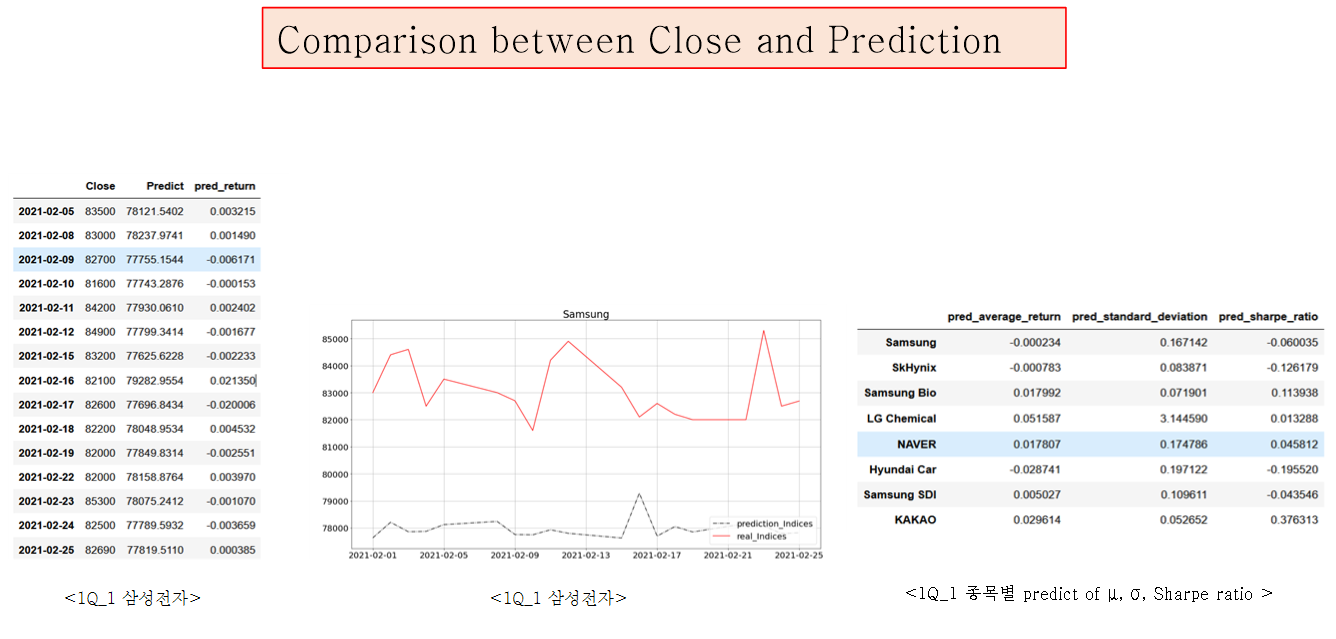

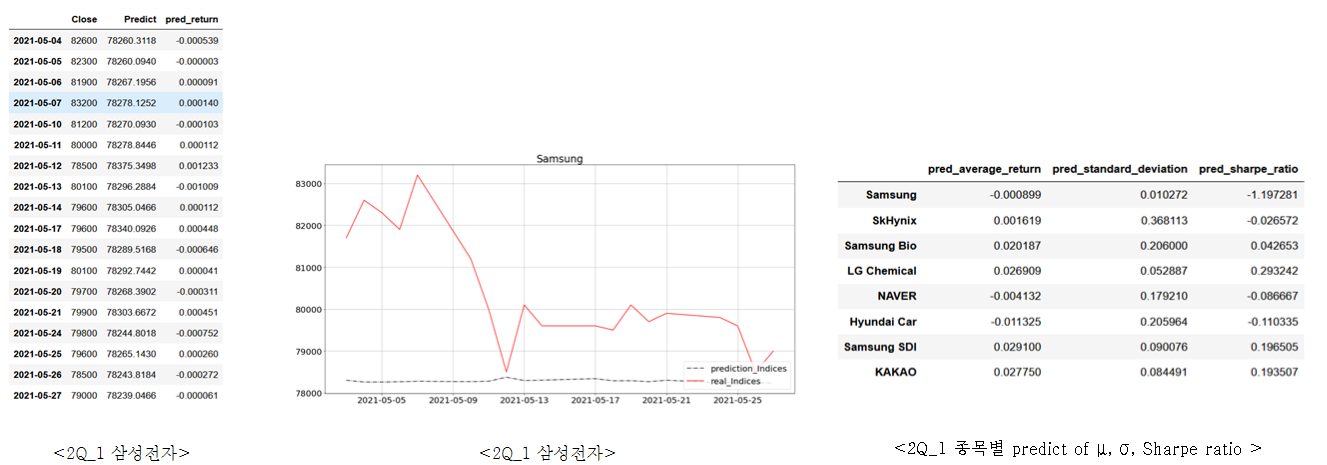

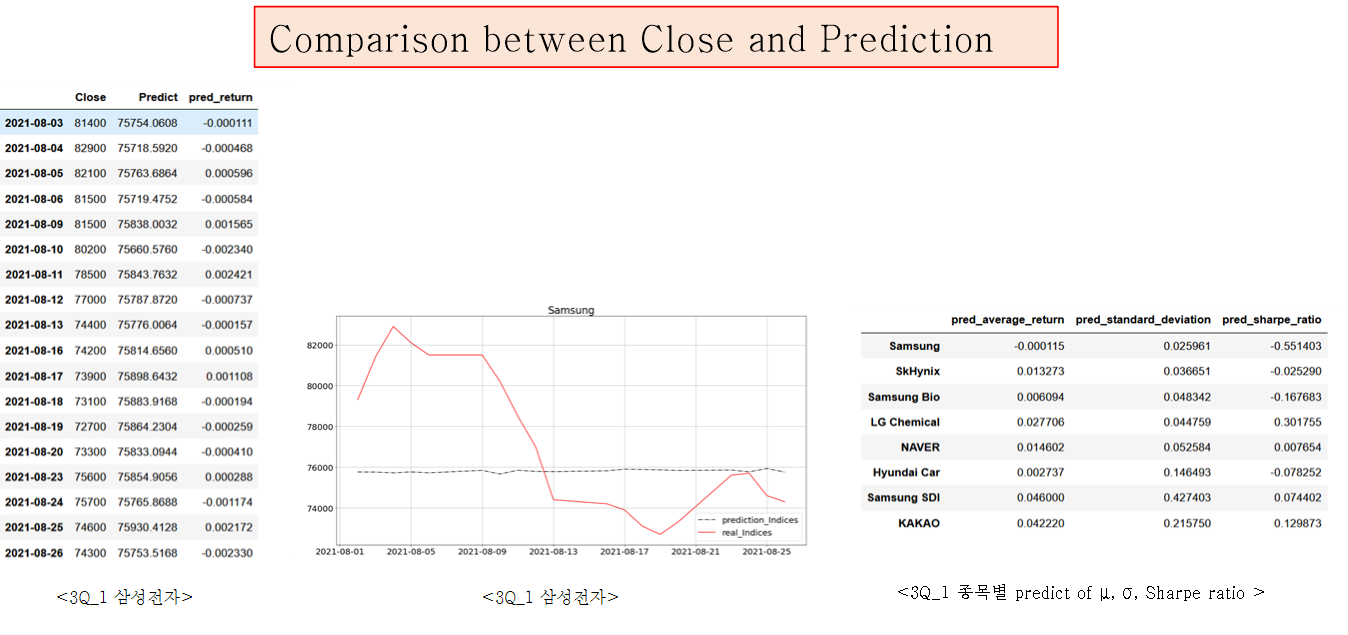